### Scope of code

- Using networkx construct a simple network e.g., 10 nodes and some random edges with weights
- Then randomly select e.g., 30 OD queries and run their shortest paths
    - As a variant of this, run k-sp and select a random k for each OD
- From this construct an link-path matrix
- Observe flow vector f_a
- Construct path flow vector
- Construct matrix f
- Constract the assignment matrix

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from collections import Counter

# Function to generate random OD queries
def generate_random_OD_queries(graph, num_queries):
    nodes = list(graph.nodes())
    queries = []
    trip_id = 0
    for _ in range(num_queries):
        origin, destination = random.sample(nodes, 2)
        queries.append((trip_id,origin, destination))
        trip_id += 1
    return queries

# Function to find shortest path for each OD query
def find_shortest_paths(graph, queries):
    shortest_paths = {}
    for query in queries:
        origin, destination = query
        shortest_path = nx.shortest_path(graph, source=origin, target=destination, weight='length')
        shortest_paths[query] = shortest_path
    return shortest_paths

/tmp/ipykernel_1822/4076959124.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Part 1. Set up the network. Keep simple.

<function matplotlib.pyplot.show(close=None, block=None)>

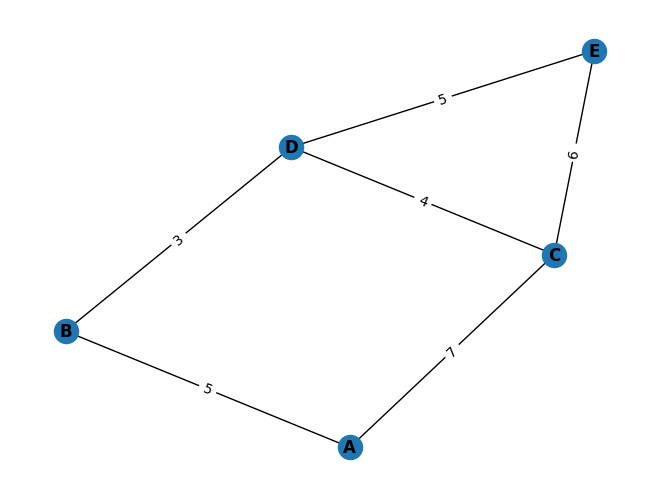

In [2]:
# Non-Directed Graph


# Create an empty graph
G = nx.Graph()

# Add nodes
nodes = ["A", "B", "C", "D", "E"]
G.add_nodes_from(nodes)

# Add edges with attributes
edges = [
    ("A", "B", {'length': 5, 'traffic_speed': 60}),
    ("A", "C", {'length': 7, 'traffic_speed': 50}),
    ("B", "D", {'length': 3, 'traffic_speed': 70}),
    ("C", "D", {'length': 4, 'traffic_speed': 55}),
    ("C", "E", {'length': 6, 'traffic_speed': 45}),
    ("D", "E", {'length': 5, 'traffic_speed': 65}),
]

G.add_edges_from(edges)

#Visualise Network

pos = nx.spring_layout(G)  # positions for all nodes

nx.draw(G, pos, with_labels=True, font_weight='bold')

# Edge labels
edge_labels = nx.get_edge_attributes(G, 'length')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show

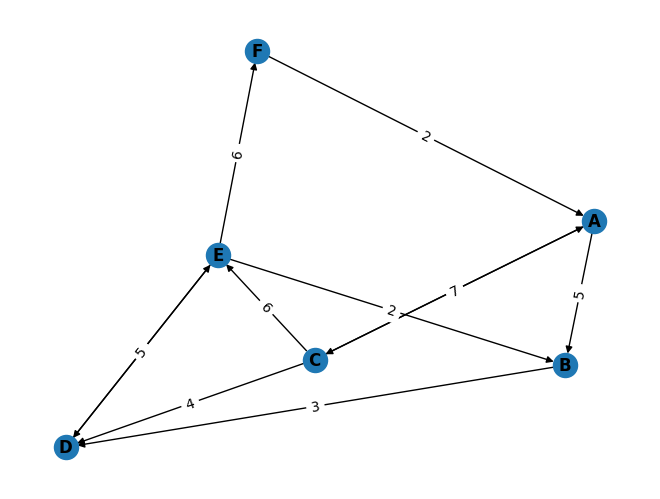

In [4]:
#Directed Graph

G = nx.DiGraph()  # Making the graph directed

# Add nodes
nodes = ["A", "B", "C", "D", "E"]
G.add_nodes_from(nodes)

# Add directed edges with attributes
edges = [
    ("A", "B", {'length': 5, 'traffic_speed': 60}),
    ("A", "C", {'length': 7, 'traffic_speed': 50}),
    ("C", "A", {'length': 7, 'traffic_speed': 50}),
    ("B", "D", {'length': 3, 'traffic_speed': 70}),
    ("C", "D", {'length': 4, 'traffic_speed': 55}),
    ("C", "E", {'length': 6, 'traffic_speed': 45}),
    ("D", "E", {'length': 5, 'traffic_speed': 65}),
    ("E", "B", {'length': 2, 'traffic_speed': 75}),
    ("E", "D", {'length': 5, 'traffic_speed': 65}),
    ("E", "F", {'length': 6, 'traffic_speed': 65}),
    ("F", "A", {'length': 2, 'traffic_speed': 55})
]

G.add_edges_from(edges)

pos = nx.spring_layout(G)  # positions for all nodes

nx.draw(G, pos, with_labels=True, font_weight='bold', arrows=True)  # Set arrows=True to show edge directions

# Edge labels
edge_labels = nx.get_edge_attributes(G, 'length')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

### Part 2 - Generate OD Queries and get their respective shortest paths

In [5]:
# Generate 5 random OD queries
num_queries = 100
OD_queries = generate_random_OD_queries(G, num_queries)
print("Random OD Queries:", OD_queries)

Random OD Queries: [(0, 'E', 'B'), (1, 'F', 'B'), (2, 'A', 'D'), (3, 'E', 'F'), (4, 'A', 'F'), (5, 'C', 'F'), (6, 'C', 'E'), (7, 'F', 'A'), (8, 'F', 'A'), (9, 'B', 'A'), (10, 'C', 'A'), (11, 'A', 'C'), (12, 'E', 'B'), (13, 'B', 'E'), (14, 'C', 'D'), (15, 'F', 'A'), (16, 'D', 'B'), (17, 'D', 'B'), (18, 'A', 'E'), (19, 'C', 'B'), (20, 'C', 'F'), (21, 'D', 'A'), (22, 'D', 'A'), (23, 'A', 'F'), (24, 'B', 'E'), (25, 'A', 'E'), (26, 'F', 'E'), (27, 'B', 'F'), (28, 'B', 'C'), (29, 'D', 'A'), (30, 'B', 'C'), (31, 'D', 'F'), (32, 'B', 'E'), (33, 'B', 'D'), (34, 'D', 'F'), (35, 'B', 'F'), (36, 'F', 'E'), (37, 'D', 'C'), (38, 'C', 'B'), (39, 'E', 'F'), (40, 'A', 'C'), (41, 'F', 'B'), (42, 'E', 'C'), (43, 'D', 'F'), (44, 'F', 'D'), (45, 'A', 'E'), (46, 'D', 'B'), (47, 'C', 'F'), (48, 'D', 'C'), (49, 'A', 'D'), (50, 'D', 'F'), (51, 'F', 'C'), (52, 'E', 'D'), (53, 'D', 'E'), (54, 'D', 'F'), (55, 'C', 'D'), (56, 'A', 'B'), (57, 'D', 'F'), (58, 'A', 'C'), (59, 'F', 'D'), (60, 'E', 'C'), (61, 'A', 'F')

In [127]:
#Case 1 - all queries get their shortest path

sp1 = {}

#Get Shortest Paths
sp_to_id = {}
id_to_sp = {}
sp_to_path_id = {}
path_id = 0

for query in OD_queries:
    trip_id, origin, destination = query
    sp = nx.shortest_path(G, source=origin, target=destination, weight='length')

    #Add path to path ID
    if repr(sp) in list(sp_to_id.keys()):
        pass
    else:
        sp_to_id[repr(sp)] = path_id
        id_to_sp[path_id] = sp 
        path_id += 1
            
    sp_to_path_id[trip_id] = sp_to_id[repr(sp)]
    
sp1['Path to Path ID'] = sp_to_id
sp1['Path ID to Path'] = id_to_sp
sp1['Trip ID to Path ID'] = sp_to_path_id

#Case 2 - get top 2 shortest paths and randomly assign either

sp2 = {}

#Get Shortest Paths
sp_to_id = {}
id_to_sp = {}
sp_to_path_id = {}
od_path_ids = {}
path_id = 0

for n in G.nodes():
    od_path_ids[n] = {}
    for n2 in G.nodes():
        od_path_ids[n][n2] = []

for query in OD_queries:
    trip_id, origin, destination = query
    q_sps = [p for p in nx.all_shortest_paths(G, source=origin, target=destination, weight='length')]
    if len(q_sps) > 1:
        rand_var = random.uniform(0, 1)
        if rand_var < 0.66:
            sp = q_sps[0]
        else:
            sp = q_sps[1]        
    else:
        sp = q_sps[0]
        
    #Add path to path ID
    if repr(sp) in list(sp_to_id.keys()):
        pass
    else:
        sp_to_id[repr(sp)] = path_id
        id_to_sp[path_id] = sp 
        path_id += 1
            
    sp_to_path_id[trip_id] = sp_to_id[repr(sp)]
    od_path_ids[origin][destination].append(sp_to_id[repr(sp)])
        
sp2['Path to Path ID'] = sp_to_id
sp2['Path ID to Path'] = id_to_sp
sp2['Trip ID to Path ID'] = sp_to_path_id

### Generate the link-path matrix

Two variants of this, it is unclear which is most appropriate at this stage so generate both

1. Link path matrix for the OD set and generated paths
2. Link path matrix for all possible paths in the matrix

Case 1 - link-path matrix for observed flows

To Do - review logic as retrospectively changed to ensure binary updates. Probably not efficient when we scale to larger networks

In [128]:
# Construct path-link matrix for SP1 set

#link_path_matrix = pd.DataFrame(0, index = pd.MultiIndex.from_tuples(list(G.edges) + [(t[1], t[0]) for t in list(G.edges)]), columns = list(sp1['Path ID to Path'].keys()))
link_path_matrix = pd.DataFrame(0, index = pd.MultiIndex.from_tuples(list(G.edges) ), columns = list(sp1['Path ID to Path'].keys()))

for pathid in list(sp1['Trip ID to Path ID'].values()):
    path = sp1['Path ID to Path'][pathid]
    u = path[0]
    for v in path[1:]:
        edge = tuple([u,v])
        link_path_matrix.loc[edge,pathid] = 1
        u = v
    
sp1['Link Path Matrix'] = link_path_matrix

# Construct path-link matrix for SP2 set

#link_path_matrix = pd.DataFrame(0, index = pd.MultiIndex.from_tuples(list(G.edges) + [(t[1], t[0]) for t in list(G.edges)]), columns = list(sp1['Path ID to Path'].keys()))
link_path_matrix = pd.DataFrame(0, index = pd.MultiIndex.from_tuples(list(G.edges) ), columns = list(sp2['Path ID to Path'].keys()))

for pathid in list(sp2['Trip ID to Path ID'].values()):
    path = sp2['Path ID to Path'][pathid]
    u = path[0]
    for v in path[1:]:
        edge = tuple([u,v])
        link_path_matrix.loc[edge,pathid] = 1
        u = v

sp2['Link Path Matrix'] = link_path_matrix

In [8]:
all_pairs_paths = dict(nx.all_pairs_shortest_path(G))

#Get Shortest Paths
ap = {}
sp_to_id = {}
id_to_sp = {}
path_id = 0

for n in list(G.nodes):
    for n2 in list(G.nodes):
        if n == n2:
            continue
        else:
            sp = all_pairs_paths[n][n2]
            #Add path to path ID
            if repr(sp) in list(sp_to_id.keys()):
                pass
            else:
                sp_to_id[repr(sp)] = path_id
                id_to_sp[path_id] = sp 
                path_id += 1
ap['Path to Path ID'] = sp_to_id
ap['Path ID to Path'] = id_to_sp

#link_path_matrix = pd.DataFrame(0, index = pd.MultiIndex.from_tuples(list(G.edges) + [(t[1], t[0]) for t in list(G.edges)]), columns = list(sp1['Path ID to Path'].keys()))
link_path_matrix = pd.DataFrame(0, index = pd.MultiIndex.from_tuples(list(G.edges) ), columns = list(ap['Path ID to Path'].keys()))

for pathid in list(ap['Path ID to Path'].keys()):
    path = ap['Path ID to Path'][pathid]
    u = path[0]
    for v in path[1:]:
        edge = tuple([u,v])
        new_count = link_path_matrix.loc[edge,pathid] + 1
        link_path_matrix.loc[edge,pathid] = new_count
        u = v
ap['Link Path Matrix'] = link_path_matrix

A  B     5
   C     8
B  D     7
C  A     2
   D     1
   E     5
D  E     9
E  B     2
   D     1
   F    11
F  A    11
dtype: int64


### Link Flow Vectors

In [144]:
sp1['Link Flow Vector'] = sp1['Link Path Matrix'].sum(axis = 1)
sp2['Link Flow Vector'] = sp2['Link Path Matrix'].sum(axis = 1)
ap['Link Flow Vector'] = ap['Link Path Matrix'].sum(axis = 1)

### Path Flow Vectors

In [145]:
counts = Counter(sp1['Trip ID to Path ID'].values())
index = []
count = []
for id in list(sp1['Path ID to Path'].keys()):
    index.append(id)
    count.append(counts[id])
path_flow = pd.DataFrame(index = index, columns = ['count'])
path_flow['count'] = count
sp1['Path Flow Vector'] = path_flow

counts = Counter(sp2['Trip ID to Path ID'].values())
index = []
count = []
for id in list(sp2['Path ID to Path'].keys()):
    index.append(id)
    count.append(counts[id])
path_flow = pd.DataFrame(index = index, columns = ['count'])
path_flow['count'] = count
sp2['Path Flow Vector'] = path_flow

index = []
count = []
for id in list(ap['Path ID to Path'].keys()):
    index.append(id)
    count.append(1)
path_flow = pd.DataFrame(index = index, columns = ['count'])
path_flow['count'] = count
ap['Path Flow Vector'] = path_flow

### Test result that flow vector is matrix multiplcation of link flow matrix and path count vector

In [146]:
sp2['Link Path Matrix'].values
print(sp2['Link Path Matrix'].values.shape)
sp2['Path Flow Vector'].values
print(sp2['Path Flow Vector'].values.shape)

(11, 34)
(34, 1)


In [53]:
print(sp2['Link Path Matrix'].values)
print()
print(sp2['Path Flow Vector'].values)

[[0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0 1]]

[[5]
 [3]
 [3]
 [2]
 [4]
 [3]
 [1]
 [3]
 [1]
 [3]
 [4]
 [5]
 [2]
 [5]
 [1]
 [4]
 [7]
 [2]
 [2]
 [3]
 [5]
 [7]
 [2]
 [1]
 [3]
 [4]
 [3]
 [4]
 [3]
 [1]
 [3]
 [1]]


In [147]:
print(np.matmul(sp2['Link Path Matrix'].values,sp2['Path Flow Vector'].values))

[[17]
 [25]
 [29]
 [ 3]
 [ 2]
 [13]
 [42]
 [16]
 [ 1]
 [40]
 [37]]


### Get proprtion of path assignment
### Get OD flows

In [55]:
sp2.keys()

dict_keys(['Path to Path ID', 'Path ID to Path', 'Trip ID to Path ID', 'Link Path Matrix', 'Link Flow Vector', 'Path Flow Vector'])

In [142]:
# For each OD pair get viable paths

od_array = np.array(OD_queries)
od_flows = {}
od_flow_proprtions = {}
viable_od_paths = {}

for n in G.nodes():
    viable_od_paths[n] = {}
    od_flows[n] = {}
    od_flow_proprtions[n] = {}
    for n2 in G.nodes():
        viable_od_paths[n][n2] = []
        if n == n2:
            pass
        else:
            # Top k shortest paths (k= 2)
            q_sps = [p for p in nx.all_shortest_paths(G, source=n, target=n2, weight='length')]
            if len(q_sps) == 1:
                viable_od_paths[n][n2] = q_sps[0]
                od_flow_proprtions[n][n2] = 1
            else:
                viable_od_paths[n][n2] = q_sps[:2]
                od_flow_proprtions[n][n2] = [0.66,0.33]
                
            od_flows[n][n2] = len(od_array[(od_array[:, 1] == n) & (od_array[:, 2] == n2)])

In [ ]:
# Get flow for a link
# link AB

In [159]:
# Traditional way to get link flow on AB

np.matmul(sp2['Link Path Matrix'].loc['A','B'].values,sp2['Path Flow Vector'].values)

array([17])

6

In [ ]:
# Sum of matrix elements for k paths on edge

sum_matrix = sp2['Link Path Matrix'].loc['A','B'].values.sum()

In [68]:
sp2['Link Path Matrix'].loc['A','B'].values

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

In [70]:
# Get the indices where the value is 1
indices_of_ones = np.where(sp2['Link Path Matrix'].loc['A','B'].values == 1)[0]

In [74]:
sp2['Path Flow Vector'].values[indices_of_ones]

array([[3],
       [3],
       [1],
       [2],
       [3],
       [3]])

In [76]:
sp2

{'Path to Path ID': {"['E', 'B']": 0,
  "['F', 'A', 'B']": 1,
  "['A', 'B', 'D']": 2,
  "['E', 'F']": 3,
  "['A', 'C', 'E', 'F']": 4,
  "['C', 'E', 'F']": 5,
  "['C', 'E']": 6,
  "['F', 'A']": 7,
  "['B', 'D', 'E', 'F', 'A']": 8,
  "['C', 'A']": 9,
  "['A', 'C']": 10,
  "['B', 'D', 'E']": 11,
  "['C', 'D']": 12,
  "['D', 'E', 'B']": 13,
  "['A', 'B', 'D', 'E']": 14,
  "['C', 'E', 'B']": 15,
  "['D', 'E', 'F', 'A']": 16,
  "['A', 'C', 'E']": 17,
  "['F', 'A', 'B', 'D', 'E']": 18,
  "['B', 'D', 'E', 'F']": 19,
  "['B', 'D', 'E', 'F', 'A', 'C']": 20,
  "['D', 'E', 'F']": 21,
  "['B', 'D']": 22,
  "['F', 'A', 'C', 'E']": 23,
  "['D', 'E', 'F', 'A', 'C']": 24,
  "['E', 'F', 'A', 'C']": 25,
  "['F', 'A', 'B', 'D']": 26,
  "['F', 'A', 'C']": 27,
  "['E', 'D']": 28,
  "['D', 'E']": 29,
  "['A', 'B']": 30,
  "['E', 'F', 'A']": 31},
 'Path ID to Path': {0: ['E', 'B'],
  1: ['F', 'A', 'B'],
  2: ['A', 'B', 'D'],
  3: ['E', 'F'],
  4: ['A', 'C', 'E', 'F'],
  5: ['C', 'E', 'F'],
  6: ['C', 'E'],
  

In [103]:
sp2['Path ID to Path']

{0: ['E', 'B'],
 1: ['F', 'A', 'B'],
 2: ['A', 'B', 'D'],
 3: ['E', 'F'],
 4: ['A', 'C', 'E', 'F'],
 5: ['C', 'E', 'F'],
 6: ['C', 'E'],
 7: ['F', 'A'],
 8: ['B', 'D', 'E', 'F', 'A'],
 9: ['C', 'A'],
 10: ['A', 'C'],
 11: ['B', 'D', 'E'],
 12: ['C', 'D'],
 13: ['D', 'E', 'B'],
 14: ['A', 'C', 'E'],
 15: ['C', 'E', 'B'],
 16: ['D', 'E', 'F', 'A'],
 17: ['A', 'B', 'D', 'E', 'F'],
 18: ['A', 'B', 'D', 'E'],
 19: ['F', 'A', 'B', 'D', 'E'],
 20: ['B', 'D', 'E', 'F'],
 21: ['B', 'D', 'E', 'F', 'A', 'C'],
 22: ['D', 'E', 'F'],
 23: ['B', 'D'],
 24: ['F', 'A', 'C', 'E'],
 25: ['D', 'E', 'F', 'A', 'C'],
 26: ['E', 'F', 'A', 'C'],
 27: ['F', 'A', 'B', 'D'],
 28: ['F', 'A', 'C'],
 29: ['E', 'B', 'D'],
 30: ['D', 'E'],
 31: ['A', 'B'],
 32: ['E', 'D'],
 33: ['E', 'F', 'A']}

### Get Assignment Map for Elementary Matrix Focusing on SP2

In [ ]:
# Data type origin, destination, pathID, path, assignment probability

In [112]:
# For each OD get path IDs
# Get counts for each



In [121]:
n = 'A'
n2 = 'F'

od_level_details_list = []

for n in G.nodes():
    for n2 in G.nodes():

        #Path IDs
        pathids = od_path_ids[n][n2]
        counter = Counter(pathids)

        # For each unique path

        # Get path
        # Get p as number observed / total

        for p in counter.keys():
            path = sp2['Path ID to Path'][p]
            likelihood = counter[p] / len(pathids)
            od_level_append = {}
            od_level_append['origin'] = n
            od_level_append['destination'] = n2
            od_level_append['pathID'] = p
            od_level_append['path'] = path
            od_level_append['path count'] = counter[p]
            od_level_append['od count'] = len(pathids)
            od_level_append['prob'] = likelihood
            od_level_details_list.append(od_level_append)
            
od_level_details = pd.DataFrame(od_level_details_list)

In [122]:
od_level_details

,origin,destination,pathID,path,path count,od count,prob
0,A,B,31,"[A, B]",3,3,1.000000
1,A,C,10,"[A, C]",4,4,1.000000
2,A,D,2,"[A, B, D]",3,3,1.000000
3,A,E,14,"[A, C, E]",2,3,0.666667
4,A,E,18,"[A, B, D, E]",1,3,0.333333
5,A,F,4,"[A, C, E, F]",3,4,0.750000
6,A,F,17,"[A, B, D, E, F]",1,4,0.250000
7,B,A,8,"[B, D, E, F, A]",1,1,1.000000
8,B,C,21,"[B, D, E, F, A, C]",5,5,1.000000
9,B,D,23,"[B, D]",2,2,1.000000


In [123]:
o = 'A'
d = 'E'

In [167]:
path_indeces_of_edge = np.where(sp2['Link Path Matrix'].loc['A','B'].values == 1)[0]
print(path_indeces_of_edge)

[ 1  2  4 17 18 26 30]


In [136]:
od_level_details.iloc[path_indeces_of_edge][['od count','prob']].values

array([[4.        , 1.        ],
       [3.        , 1.        ],
       [3.        , 0.33333333],
       [7.        , 1.        ],
       [5.        , 1.        ],
       [3.        , 0.66666667],
       [4.        , 1.        ]])

In [138]:
od_level_details.iloc[path_indeces_of_edge]['od count'].values

array([4, 3, 3, 7, 5, 3, 4])

In [139]:
np.multiply(od_level_details.iloc[path_indeces_of_edge]['od count'].values,od_level_details.iloc[path_indeces_of_edge]['prob'].values)

array([4., 3., 1., 7., 5., 2., 4.])

In [140]:
np.multiply(od_level_details.iloc[path_indeces_of_edge]['od count'].values,od_level_details.iloc[path_indeces_of_edge]['prob'].values).sum()

26.0

In [175]:
part1 = sp2['Link Path Matrix'].loc['A','B'].values
part2 = (od_level_details['path count'] * od_level_details['prob']).values

In [176]:
np.matmul(part1,part2)

24.666666666666668

In [179]:
(od_level_details['path count'] * od_level_details['prob']).values[path_indeces_of_edge].sum()

24.666666666666664

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])